In [345]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import make_scorer, mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold, KFold, ShuffleSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [4]:
df17 = pd.read_csv('df17.csv')

Function that returns X_train, X_test, y_train, y_test 

inputs:  

    dataframe,
    categorical features, 
    numerical features, 
    prediction (col), 
    scalar (StandardScaler(), MinMaxScaler()), 
    splitting method (accepts Kfold,StratifiedKFold, ShuffleSplit, or train_test_split as 'kf', 'skf', 'ss', 'tt'),
    test_size (float),
    random_state (int),
    LGBM (bool): for processing data for Light GBM algorithm which requires different categorical encoding. 

    

In [3]:
from sklearn.model_selection import train_test_split, KFold, GroupKFold
from sklearn.preprocessing import MinMaxScaler

def split_train_test(X, y, test_size=0.2, random_state=42, stratify=None):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=test_size, 
        random_state=random_state,
        stratify=stratify
    )
    return X_train, X_test, y_train, y_test


def split_kfold(X, y, test_size=0.2, random_state=42, n_splits=None):

    if n_splits is None:
        if test_size <= 0 or test_size >= 1:
            raise ValueError("test_size must be between 0 and 1")
        n_splits = int(round(1 / test_size))
        
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    for train_index, test_index in kf.split(X):
        yield X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]


def split_scale(df, cat_feats, num_feats, pred, scalar, split_method, test_size, rs, LGBM=False, n_splits=None, stratify=None):
                
    if pred not in df.columns:
        raise ValueError(f"Prediction column '{pred}' is not in the DataFrame columns.")

    X = pd.concat([df[cat_feats].astype('category'), df[num_feats]], axis=1)
    y = df[pred]
    
    try:
        validate_feature_types(X, cat_feats, num_feats)
    except ValueError as e:
        print(f"Validation error: {e}")

    # Encode Categorical Variables. LightGBM does not use one hot encoding. CatBoost uses 'string'.

    if LGBM == False:
        X_c = pd.get_dummies(X[cat_feats])
        X = pd.concat([X_c, X[num_feats]], axis=1)

    if LGBM == 'cat':
        X[cat_feats] = X[cat_feats].astype('str')
     
    # Define split functions
    split_functions = {
        'tt': lambda X, y: split_train_test(X, y, test_size=test_size, random_state=rs, stratify=None),
        'kf': lambda X, y: split_kfold(X, y, test_size=test_size, random_state=rs, n_splits=n_splits)
    }
    
    split_func = split_functions.get(split_method)
    
    if split_func:
        if split_method == 'tt':
            X_train, X_test, y_train, y_test = split_func(X, y)
        else:
            X_train, X_test, y_train, y_test = next(split_func(X, y))
    else:
        raise ValueError(f"{split_method} is not valid. Please use a valid split method ('tt' or 'kf').")
      
    # Scale Data 
    if scalar:
        X_train[num_feats] = scalar.fit_transform(X_train[num_feats])
        X_test[num_feats] = scalar.transform(X_test[num_feats])
        
    return X_train, X_test, y_train, y_test

In [5]:
def validate_feature_types(df, cat_feats, num_feats):

    for cat in cat_feats:
        if cat not in df.columns:
            raise ValueError(f"Categorical feature '{cat}' is not in the DataFrame columns.")
        if not isinstance(df[cat].dtype, pd.CategoricalDtype):
            raise ValueError(f"Column '{cat}' is expected to be categorical but is not.")

    for num in num_feats:
        if num not in df.columns:
            raise ValueError(f"Numerical feature '{num}' is not in the DataFrame columns.")
        if isinstance(df[num].dtype, pd.CategoricalDtype):
            raise ValueError(f"Column '{num}' is expected to be numerical but is categorical.")
        if df[num].dtype == 'object':
            raise ValueError(f"Column '{num}' is expected to be numerical but has dtype 'object'.")

# Initial Feature Set

In [6]:
cat_feats = ['Turbo', 'BodyClass', 'FuelTypePrimary', 'EngineCylinders', 'VehicleType', 'DriveType','GVWR', 'Doors', 'paint_color']
num_feats = ['odometer', 'ModelYear', 'displ']

Scoring Function to see Error per prediction instead of MSE which shows an extremely large number that is hard to interpret.

In [7]:
def get_rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

rmse_scorer = make_scorer(get_rmse, greater_is_better=False)

In [8]:
import time

def search_model(n_iter, model, params, folds, X_train, X_test, y_train, y_test):

    if n_iter == 'grid':
        search = GridSearchCV(estimator=model, param_grid=params, scoring=rmse_scorer, cv=folds)
        
    else:
        search = RandomizedSearchCV(estimator=model, param_distributions=params, n_iter=n_iter,
                        scoring='neg_root_mean_squared_error', cv=folds, n_jobs=-1, verbose=2, return_train_score=True)
        
    start_time = time.time()
    search.fit(X_train, y_train)
    end_time = time.time()
    
    best_model = search.best_estimator_
    best_model.fit(X_train, y_train)
    
    y_test_pred = best_model.predict(X_test)
    y_train_pred = best_model.predict(X_train)
    
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
           
    if hasattr(best_model, 'feature_names_'):
        feature_names = best_model.feature_names_
    elif hasattr(best_model, 'feature_names_in'):
        feature_names = best_model.feature_names_in
    else:
        feature_names = X_train.columns
        
    if hasattr(best_model, 'feature_importances_'):
        feat_imps = best_model.feature_importances_
        #feature_importance_dict = dict(zip(feature_names, feat_imps))
    elif hasattr(best_model, 'coef_'):
        feat_imps = best_model.coef_
        #feature_importance_dict = dict(zip(feature_names, feat_imps))
    elif hasattr(best_model, 'estimators_'):
        feat_imps = best_model.estimators_
        #feature_importance_dict = dict(zip(feature_names, feat_imps)) 
    else:
        feat_imps = ''
        #feature_importance_dict = {}

    if len(feature_names) != len(feat_imps):
        feature_importance_dict = feat_imps
        print('Feature Importances Error')
        print('length feature names: ' + str(len(feature_names)))
        print('length of feature importances: ' + str(len(feat_imps)))
    else:
        feature_importance_dict = dict(zip(feature_names, feat_imps))         
        
    elapsed_time = end_time - start_time    
    
    return train_rmse, test_rmse, search.best_params_, feature_importance_dict, elapsed_time

In [ ]:
top_mods

In [10]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, ExtraTreesRegressor, RandomForestRegressor, VotingRegressor,  AdaBoostRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge,  SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

import xgboost as xgb
from xgboost import XGBRegressor

import lightgbm as lgb
from lightgbm import LGBMRegressor

from sklearn.neural_network import MLPRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import RandomizedSearchCV

from scipy.stats import randint, uniform

### The params to use as we search each model with RandomizedSearchCV.

In [11]:
# parameters to use in tests

linear_params = {
    'fit_intercept': [True, False],
    'copy_X': [True, False]
}

ridge_params = {'alpha': np.logspace(-6, 6, 13)}

lasso_params = {'alpha': np.logspace(-6, 6, 13), 'max_iter':[1000], 'tol':[0.01]}

dt_grid = {
    'ccp_alpha': np.arange(0, 0.1, 0.01).tolist(),
    'max_depth': [None] + list(np.arange(5, 21, 2)),
    'max_features': [None, 'sqrt', 'log2'] + np.linspace(0.1, 1.0, 5).tolist(),
    'max_leaf_nodes': [None] + list(np.arange(10, 101, 10)),
    'min_impurity_decrease': np.arange(0, 0.1, 0.01).tolist(),
    'min_samples_leaf': np.arange(1, 21, 2).tolist(),
    'min_samples_split': np.arange(2, 21, 2).tolist(),
    'min_weight_fraction_leaf': np.linspace(0, 15, 1).tolist()
}

rf_params = {'n_estimators': randint(50, 500), 'max_features': [None, 'sqrt', 'log2', 0.5, 0.8], 'max_depth': randint(5, 25), 
             'min_samples_split': randint(2, 20), 'min_samples_leaf': randint(1, 20), 'bootstrap': [True, False]}

bag_params =  {'estimator': [DecisionTreeRegressor(), None], 'n_estimators': np.arange(50, 501, 50).tolist(),     
        'max_samples': np.linspace(0.5, 1.0, 6).tolist(),  'max_features': np.linspace(0.5, 1.0, 6).tolist(), 
        'bootstrap': [True, False],  'bootstrap_features': [True, False]}

extra_tree_params = {'n_estimators': np.arange(50, 301, 50).tolist(), 'max_depth': [None] + np.arange(10, 51, 5).tolist(),
        'min_samples_split': np.arange(2, 21, 2).tolist(),   
        'min_samples_leaf': np.arange(1, 21, 2).tolist(), 
        'max_features': [None, 'sqrt', 'log2'] + np.linspace(0.1, 1.0, 5).tolist(),
        'bootstrap': [True, False]}

xgb_params = {'objective': ['reg:squarederror'],
        'n_estimators': [175, 200, 225],  
        'max_depth': [10,11,12, 13],         
        'learning_rate': [0.05, 0.06, 0.8, 0.07, 0.09, 0.1],  
        'colsample_bytree': [0.8, 0.6, 0.7],    
        'subsample': [0.7, 0.8, 0.6],
        'min_child_weight': [7, 9, 11, 15, 13],
        'lambda': [1.5, 2.5, 2, 3, 3.5, 4, 4.5, 5],
        'colsample_bynode': [0.6, 0.8, 0.4], 
        'colsample_bylevel': [0.6, 0.8, 0.4],
        'scale_pos_weight': [1, 2, 5]}

lgbm_params = {'num_leaves': [31, 50, 100],
 'learning_rate': [0.025, 0.05, 0.075, 0.1],
 'n_estimators': [120, 200, 320],
 'max_depth': [-1, 8, 10, 12, 20],
 'min_child_samples': [20, 50, 100],
 'subsample': [0.6, 0.8, 1.0],
 'colsample_bytree': [0.6, 0.8, 1.0],
'feature_fraction': [0.9, 0.75, 1],
'verbose': [-1]}


mlp_params = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'activation': ['relu'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'learning_rate_init': [0.001, 0.01, 0.1],
    'max_iter': [200, 500, 1000],
    'batch_size': [16, 32, 64, 128]
}

sgd_params = {
    'loss': ['squared_error', 'huber'],
    'penalty': ['none', 'l2'],
    'alpha': [0.0001, 0.01],
    'l1_ratio': [0.0, 0.5],
    'learning_rate': ['constant'],
    'eta0': [0.01],
    'max_iter': [1000],
    'tol': [1e-4]
}

param_grid_knn = {
    'n_neighbors': [3, 5, 7, 10, 15, 20],  # Number of neighbors to use
    'weights': ['uniform', 'distance'],     # Weight function used in prediction
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # Algorithm to compute the nearest neighbors
    'p': [1, 2]  # Power parameter for the Minkowski distance
}

param_dist_svr = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Kernel type
    'C': [0.1, 1, 10, 100],                          # Regularization parameter
    'gamma': ['scale', 'auto'] + list(np.logspace(-3, 3, 7)),  # Kernel coefficient
    'epsilon': [0.01, 0.1, 0.5, 1]                   # Epsilon in the epsilon-SVR model
}

ada_params = {
    'n_estimators': [50, 100, 150, 200],       # Number of boosting stages
    'learning_rate': [0.01, 0.1, 1.0, 10],     # Step size shrinking to prevent overfitting
    'estimator': [DecisionTreeRegressor(max_depth=d) for d in [5, 7, 9, 11, 13]]  # Base model
}

cat_params = {
    'cat_features' : [cat_feats],
    'iterations': np.arange(200,701,100),
    'depth': np.arange(4,16,1),
    'learning_rate': np.arange(0.025, 0.201, .025),
    'l2_leaf_reg': np.arange(2, 11, 1),
    'silent': [True]
}

#### Mega Dictionary: Combining all the param dictionaries with their respective regressors.

In [12]:
#First Batch:

model_dc = {
            'SGD': [SGDRegressor(), sgd_params],
        'CatBoost' : [CatBoostRegressor(), cat_params],
        'Linear' : [LinearRegression(), linear_params],
        'Ridge' : [Ridge(), ridge_params], 
        'Lasso' : [Lasso(), lasso_params], 
        'RandomForest' : [RandomForestRegressor(), rf_params], 
        'Bagging' : [BaggingRegressor(), bag_params],
        'ExtraTrees' : [ExtraTreesRegressor(), extra_tree_params],
        'XGBoost' :  [xgb.XGBRegressor(enable_categorical=True), xgb_params],
        'LightGBM': [LGBMRegressor(),lgbm_params],
        'DecisionTree' : [DecisionTreeRegressor(), dt_grid],
        'AdaBoost': [AdaBoostRegressor(), ada_params],
        'MLP' : [MLPRegressor(), mlp_params],
        'KNN' : [KNeighborsRegressor(), param_grid_knn],
}

In [13]:
def verify_mod(model):

    if isinstance(model, CatBoostRegressor):
        print('CatBoost Detected')
        return 'cat'
    elif isinstance(model, LGBMRegressor):
        print('LightGBM Detected')
        return True
    else:
        return False        

In [14]:
def split_search_v2(df, cat_feats, num_feats, pred, scalar, split_method, ts, rs, n_iter, folds, model_dc):

    ret_dc = {}
    
    cs = ['train','test','parameters', 'importances', 'search_time']
    
    for k,v in model_dc.items():
        
        model = v[0]
        params = v[1]
        LGBM = verify_mod(model)

        print(model)
        
        X_train, X_test, y_train, y_test = split_scale(df, cat_feats, num_feats, pred, scalar, split_method, ts, rs, LGBM)
        ret_dc[k] = search_model(n_iter, model, params, folds, X_train, X_test, y_train, y_test)

    f_df = pd.DataFrame.from_dict(ret_dc, orient='index', columns=cs)

    f_df['split_method'] = split_method
    f_df['random_state'] = rs
    f_df['test_size'] = ts
    f_df['scalar'] = scalar
    f_df['n_iter'] = n_iter
    f_df['folds'] = folds
    
    return f_df

In [51]:
df_scores = split_search_v2(df17, cat_feats, num_feats, 'price', StandardScaler(), 'tt', 0.2, 42, 2, 3, model_dc)

SGDRegressor()
Fitting 3 folds for each of 2 candidates, totalling 6 fits


C:\Users\pgrts\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\pgrts\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Fitting 3 folds for each of 2 candidates, totalling 6 fits
LinearRegression()
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Ridge()
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Lasso()
Fitting 3 folds for each of 2 candidates, totalling 6 fits


C:\Users\pgrts\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.299e+11, tolerance: 1.309e+11
  model = cd_fast.enet_coordinate_descent(
C:\Users\pgrts\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.299e+11, tolerance: 1.309e+11
  model = cd_fast.enet_coordinate_descent(


RandomForestRegressor()
Fitting 3 folds for each of 2 candidates, totalling 6 fits
BaggingRegressor()
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Feature Importances Error
length feature names: 68
length of feature importances: 250
ExtraTreesRegressor()
Fitting 3 folds for each of 2 candidates, totalling 6 fits
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, 

## Initial Results
>Only 3 folds with 2 candidates are used to speed up processing time.

In [245]:
df_scores.sort_values(by='test')

,train,test,parameters,importances,search_time,split_method,random_state,test_size,scalar,n_iter,folds
LightGBM,4724.910675,5459.399072,"{'verbose': -1, 'subsample': 1.0, 'num_leaves'...","{'Turbo': 766, 'BodyClass': 1260, 'FuelTypePri...",4.262176,tt,42,0.2,StandardScaler(),2,3
XGBoost,4463.667313,5470.608748,"{'subsample': 0.8, 'scale_pos_weight': 2, 'obj...","{'Turbo_0': 0.01258885, 'Turbo_1': 0.021394037...",9.205291,tt,42,0.2,StandardScaler(),2,3
CatBoost,5153.920142,5612.413089,"{'silent': True, 'learning_rate': 0.025, 'l2_l...","{'Turbo': 3.3497951894669673, 'BodyClass': 2.1...",163.767794,tt,42,0.2,StandardScaler(),2,3
ExtraTrees,4538.196658,5634.148532,"{'n_estimators': 200, 'min_samples_split': 4, ...","{'Turbo_0': 0.00793297254318659, 'Turbo_1': 0....",59.626784,tt,42,0.2,StandardScaler(),2,3
RandomForest,5217.131870,5766.575083,"{'bootstrap': True, 'max_depth': 24, 'max_feat...","{'Turbo_0': 0.006580172872551815, 'Turbo_1': 0...",110.147559,tt,42,0.2,StandardScaler(),2,3
MLP,5291.477840,5794.229933,"{'solver': 'adam', 'max_iter': 500, 'learning_...",,107.320867,tt,42,0.2,StandardScaler(),2,3
Bagging,2621.365691,5840.519302,"{'n_estimators': 250, 'max_samples': 0.9, 'max...",[DecisionTreeRegressor(random_state=1805282429...,203.491076,tt,42,0.2,StandardScaler(),2,3
KNN,56.314403,6146.399514,"{'weights': 'distance', 'p': 2, 'n_neighbors':...",,240.671185,tt,42,0.2,StandardScaler(),2,3
AdaBoost,6299.642523,6645.971086,"{'n_estimators': 200, 'learning_rate': 0.01, '...","{'Turbo_0': 0.0054349707323873815, 'Turbo_1': ...",116.397626,tt,42,0.2,StandardScaler(),2,3
DecisionTree,6820.394295,6987.675486,"{'min_weight_fraction_leaf': 0.0, 'min_samples...","{'Turbo_0': 0.0035283654411745963, 'Turbo_1': ...",0.747350,tt,42,0.2,StandardScaler(),2,3


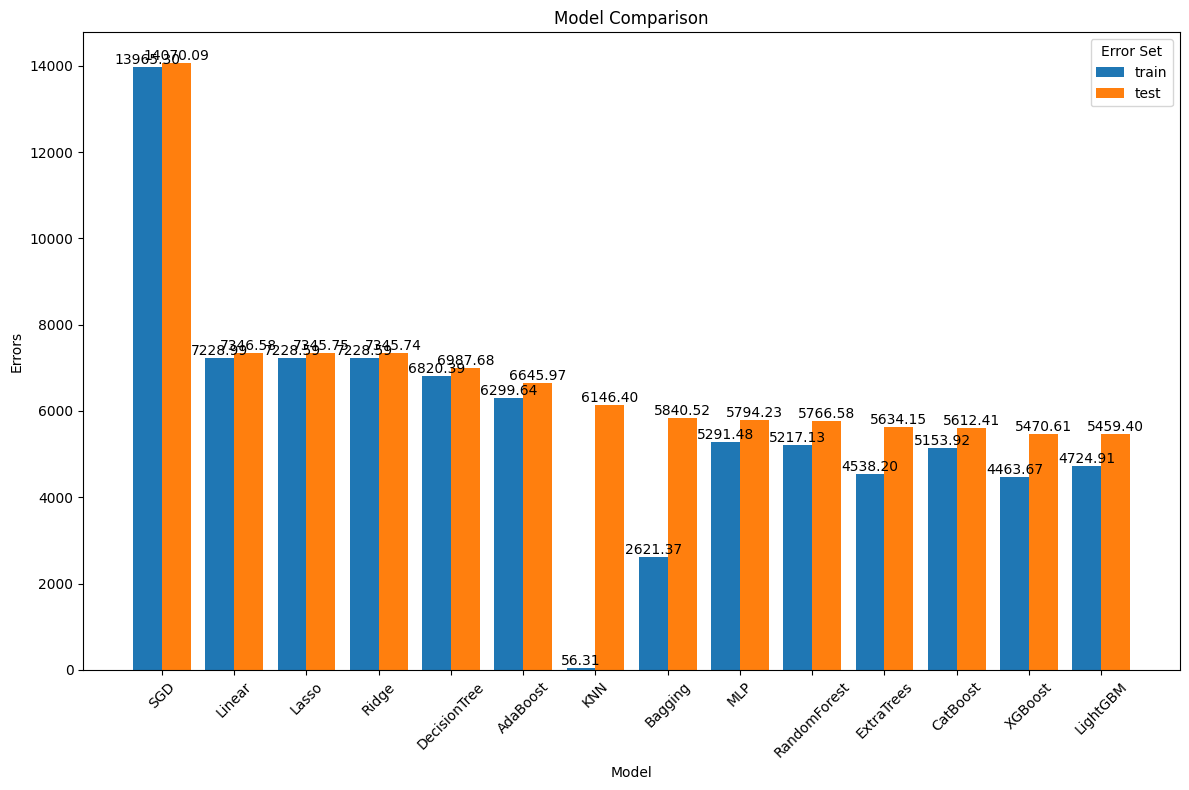

In [366]:
plot_row_values(df_scores.sort_values(by='test', ascending=False), ['train','test'])

#### First Run: Each Model's Feature Importances

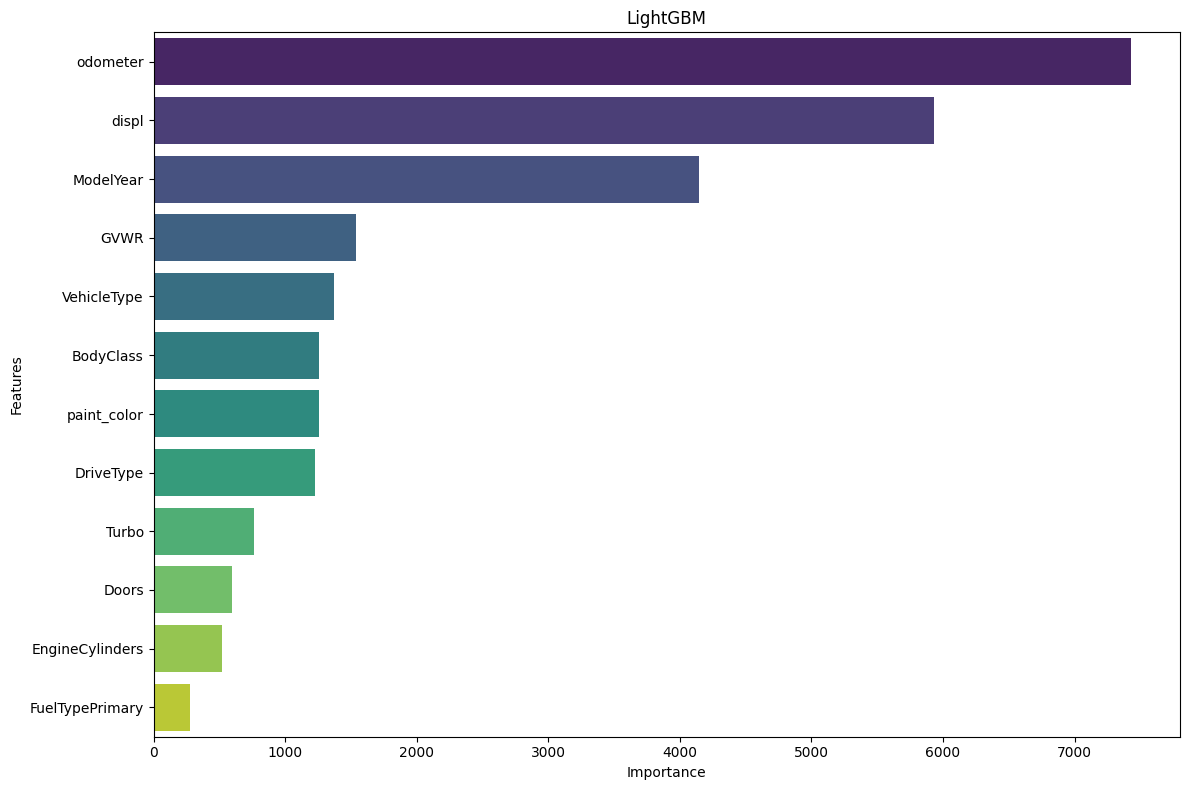

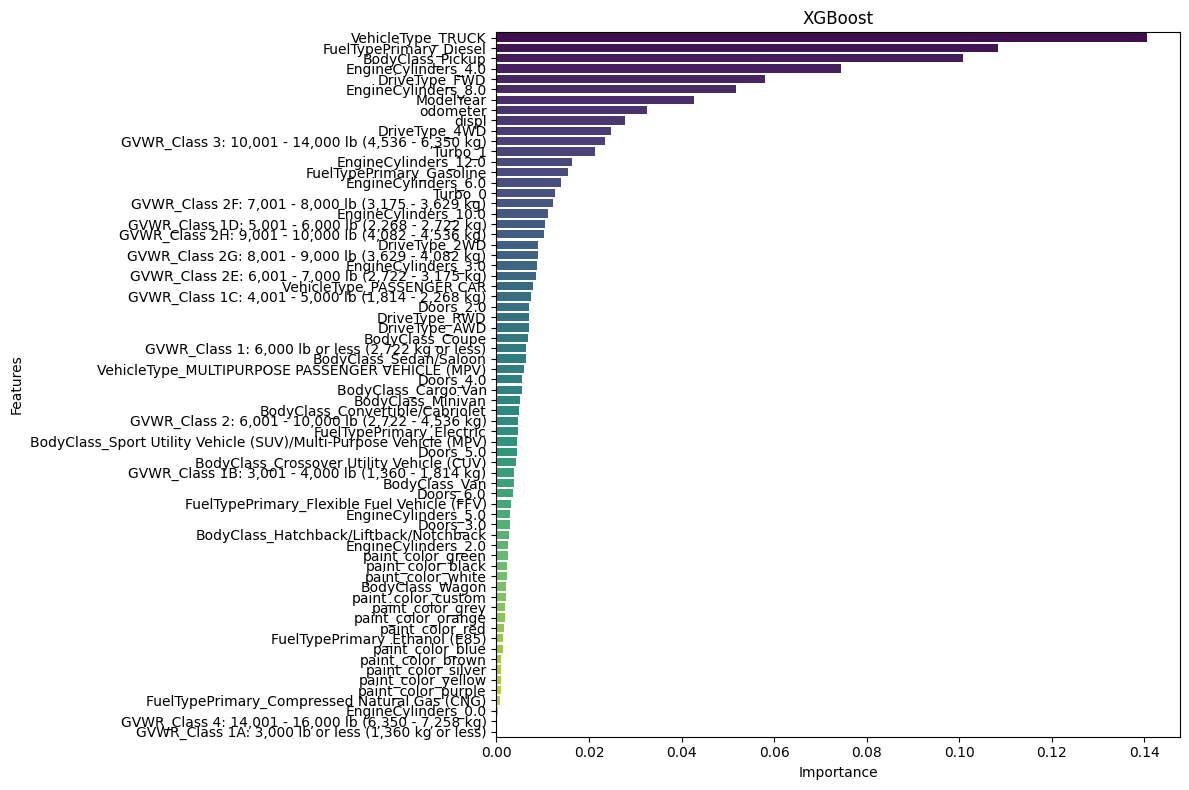

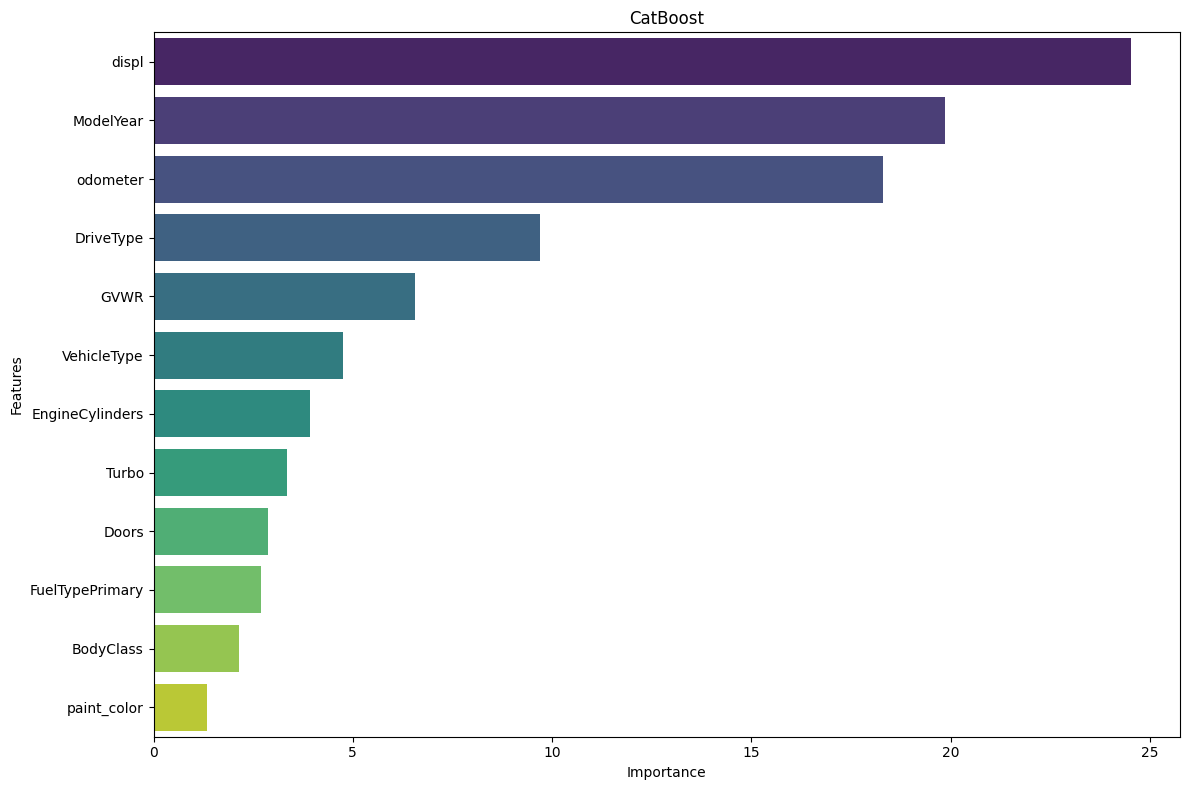

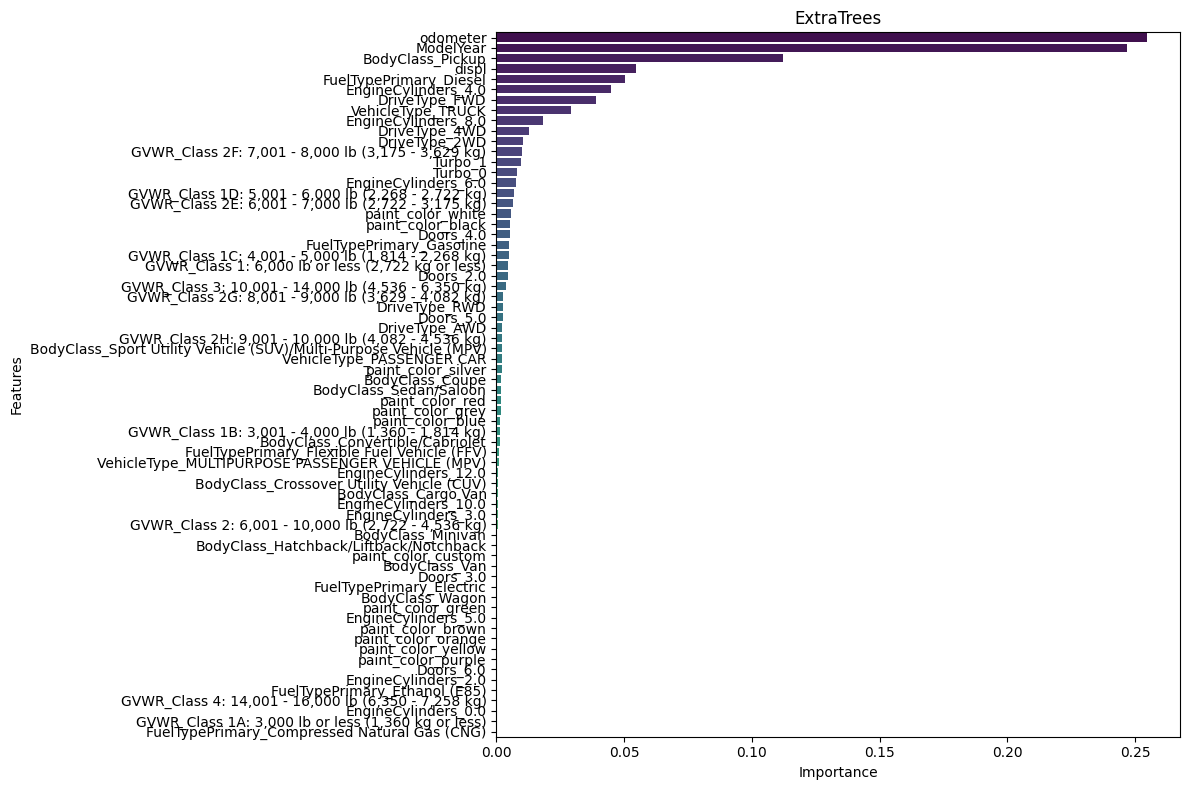

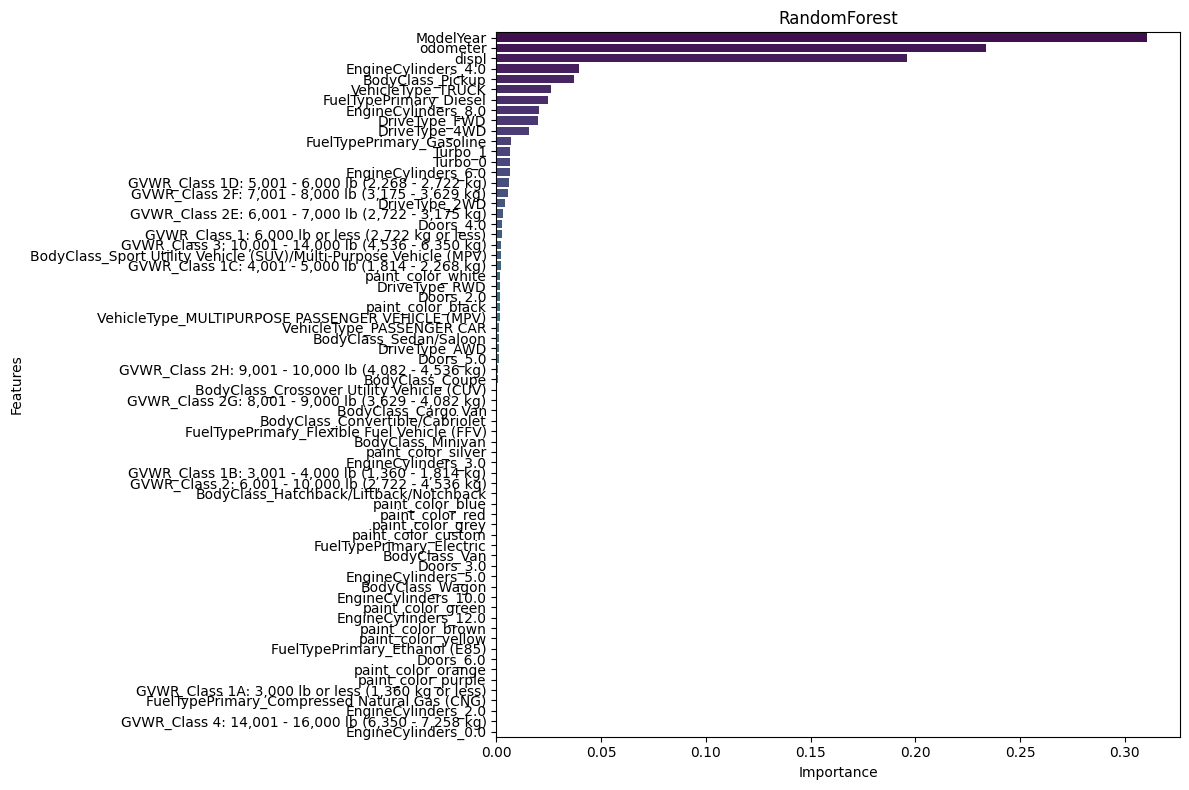

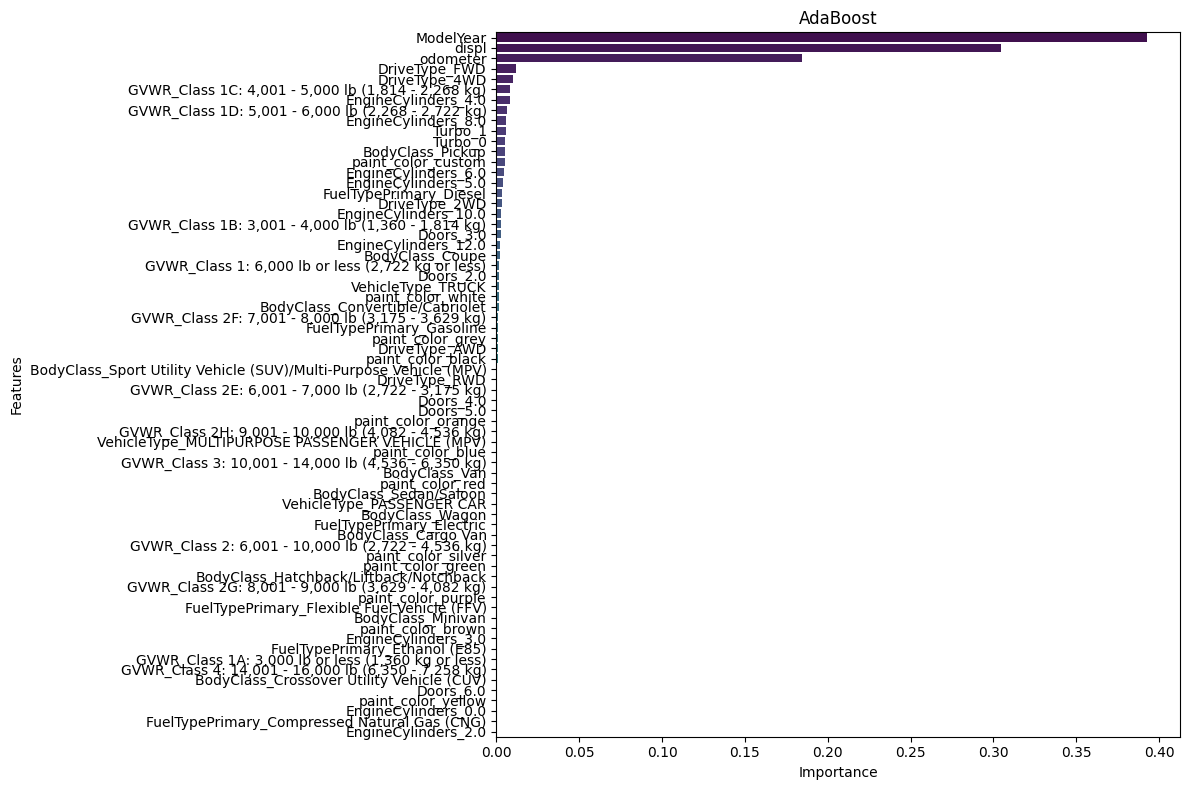

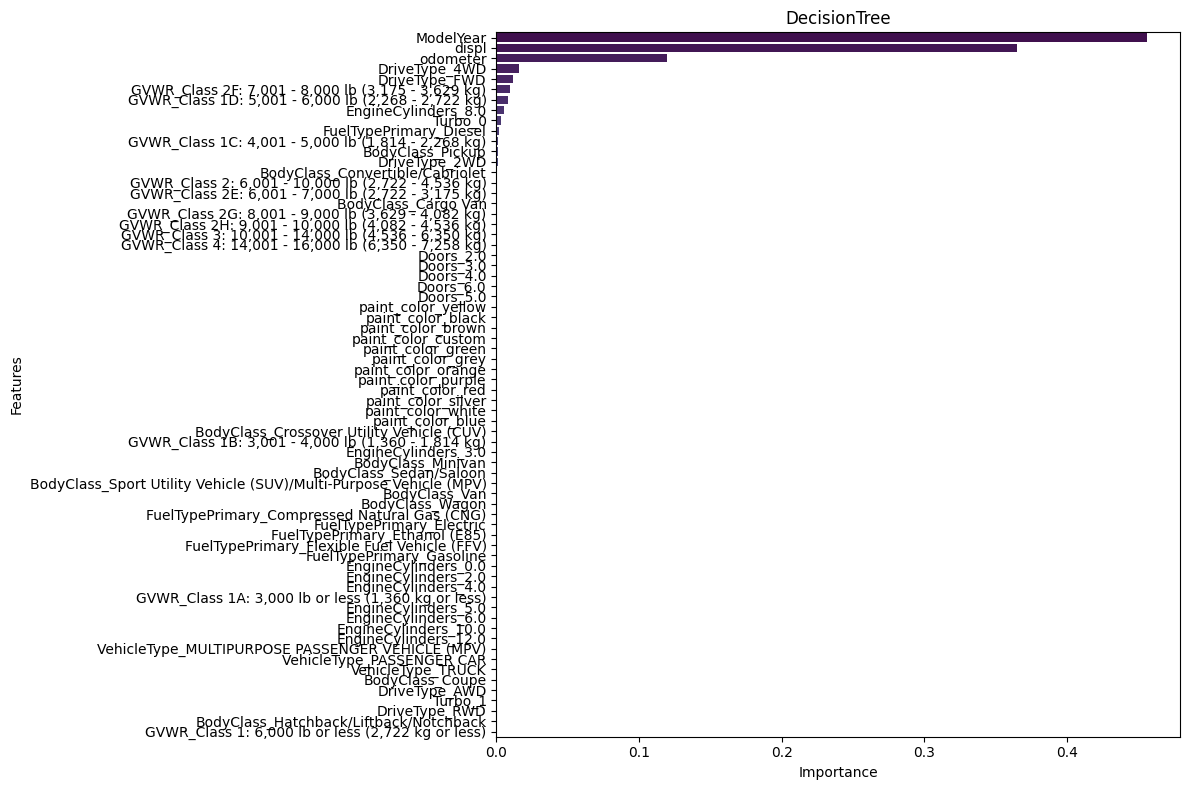

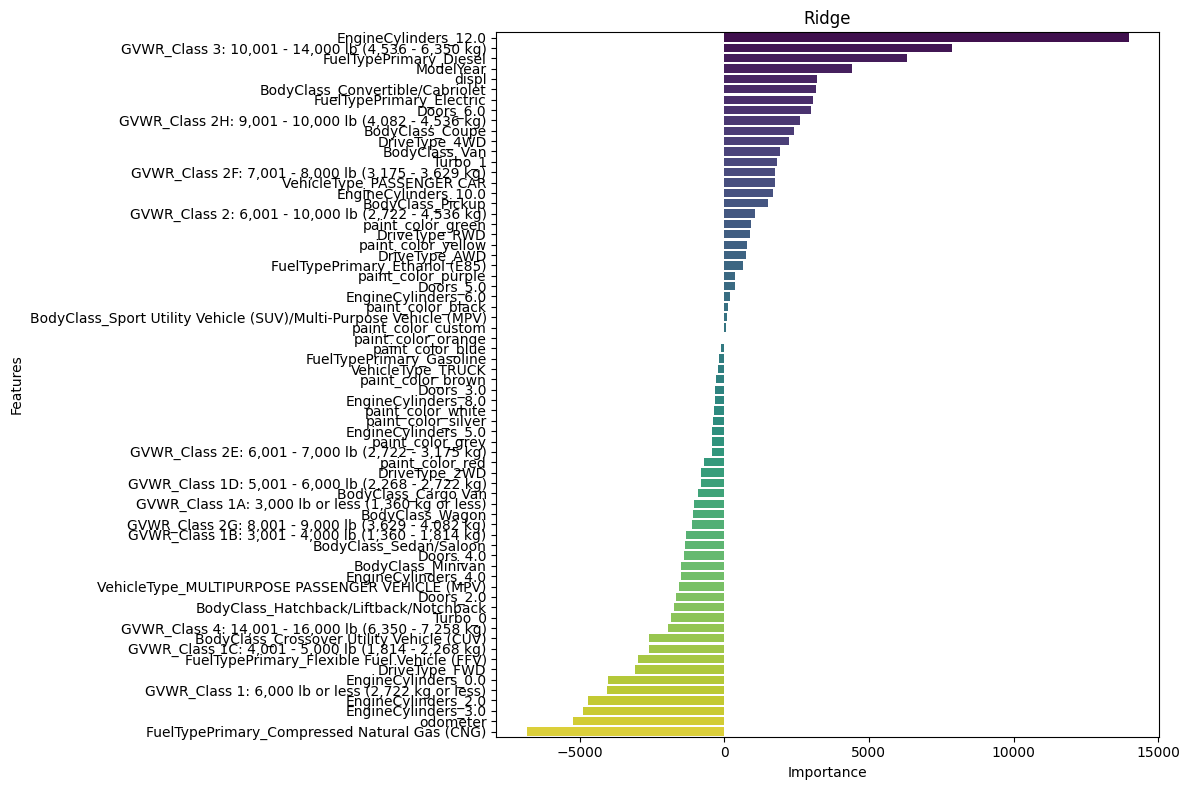

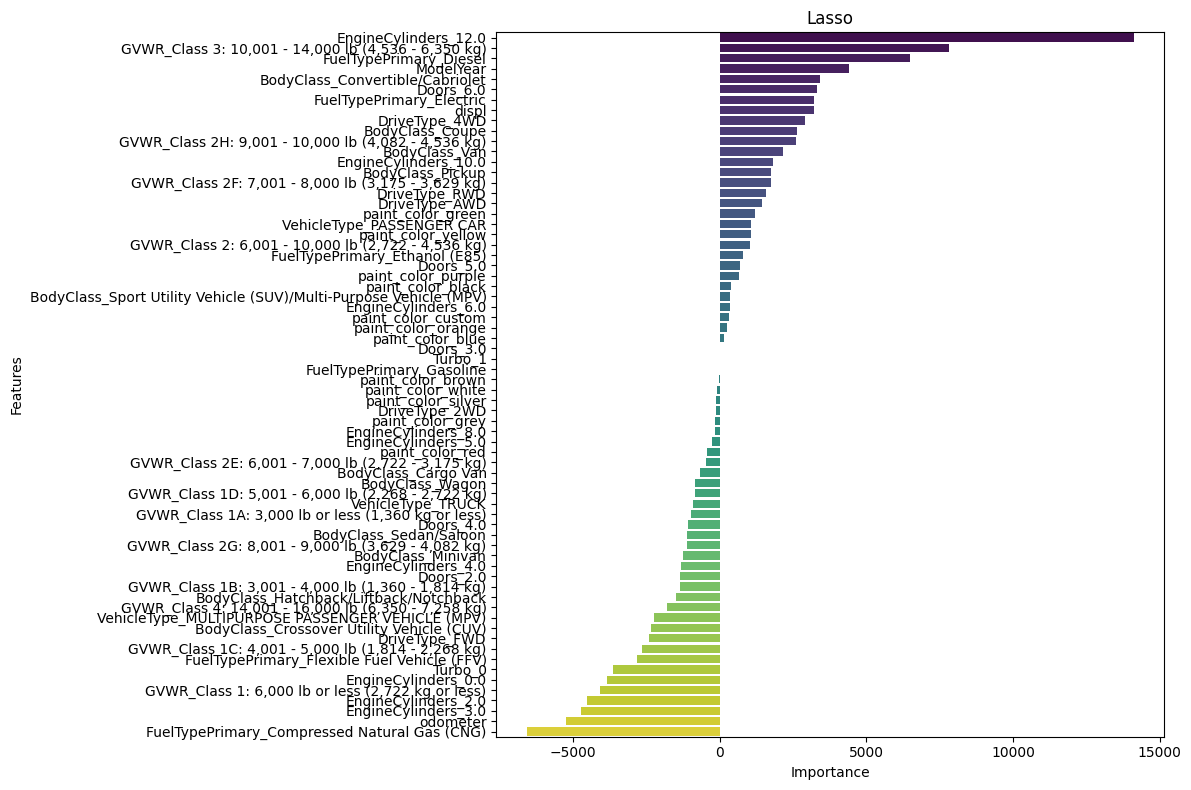

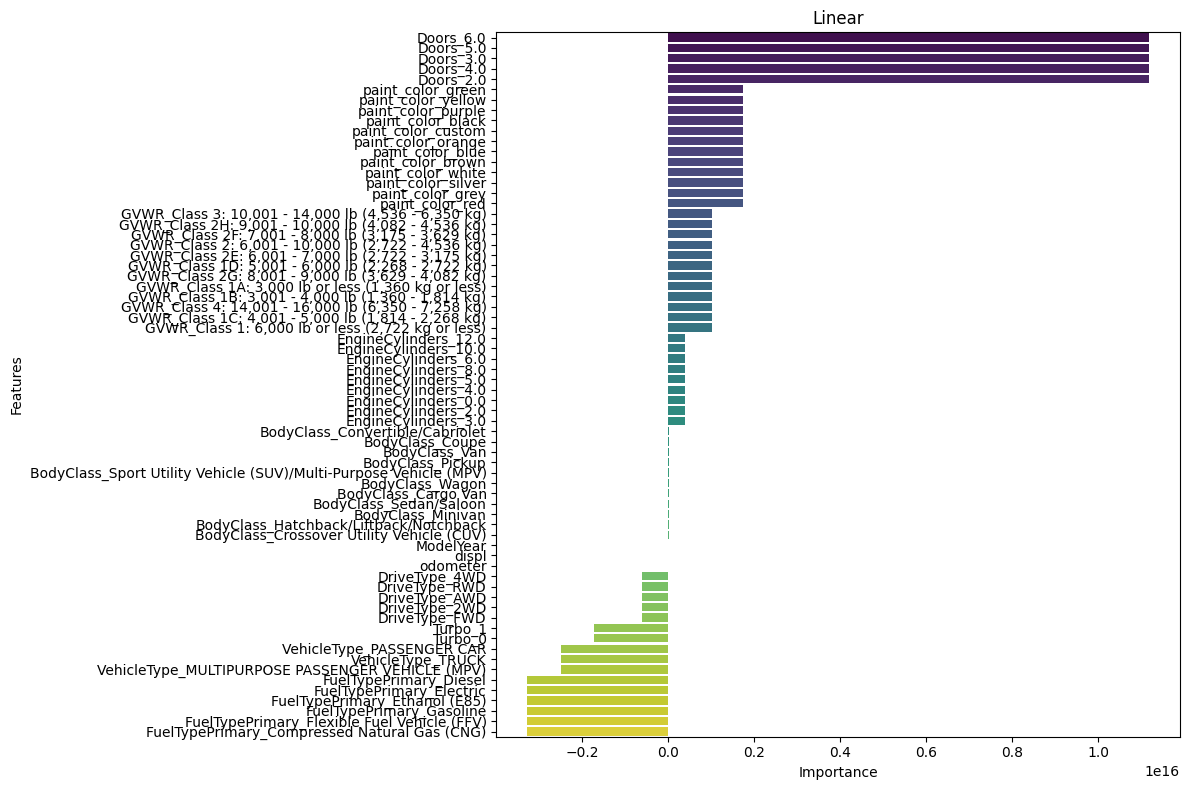

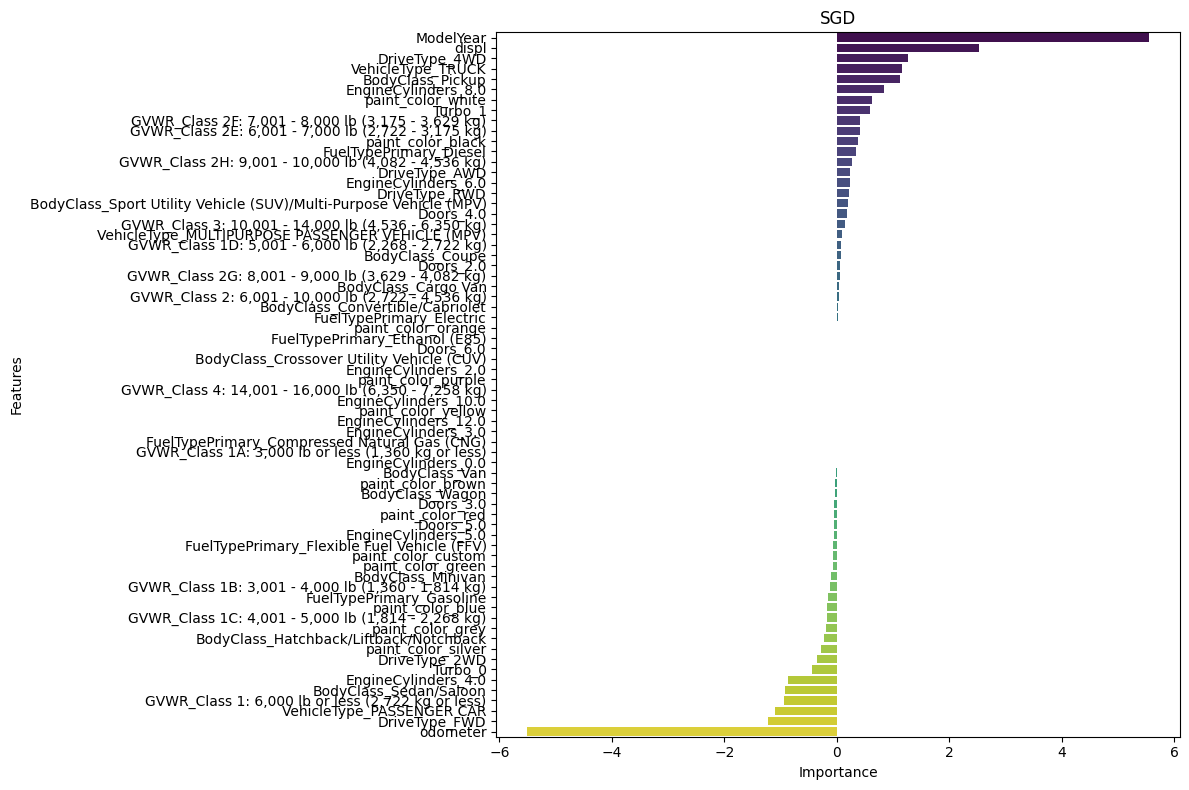

In [193]:
for mod in df_scores.sort_values(by='test').index:
    fid = df_scores.loc[mod, 'importances']
    if fid is not None and isinstance(fid, dict):
        fdf = plot_feat_imps(mod, fid)

Odometer, when prescribed less importance by SGD Regressor, throws huge errors.

# Improving Feature Set Trials

To improve score, new features using VIN decoder are used in new dataframe 'df18'.

In [15]:
df18 = df17.copy()

In [16]:
# 2021 Median state income source: https://www.statista.com/statistics/236804/median-family-income-in-the-united-states-by-state/

state_income_map = {'wy' : 86552, 'wi' : 59787, 'wv' : 48418, 'wa' : 73755, 'vt' : 61748, 'va' : 66190, 'ut' : 56000, 'tx' : 59802, 'tn' : 56616,
    'sd' : 64405, 'sc' : 52441, 'ri' : 64296, 'pa' : 64042, 'or' : 61449, 'ok' : 53808, 'oh' : 56995, 'ny' : 76753, 'nv' : 60167, 'nm' : 50292,
    'nj' : 77009, 'nh' : 73279, 'ne' : 61210, 'nd' : 64276, 'nc' : 56095, 'mt' : 56848, 'ms' : 45887, 'mo' : 55310, 'ak' : 65677, 'al' : 49671,
    'ar' : 50588, 'az' : 55574, 'ca' : 76800, 'co' : 70715, 'ct' : 82885, 'dc' : 96659, 'de' : 59846, 'fl' : 62136, 'ga' : 55846, 'hi' : 60711,
    'ia' : 57080, 'id' : 52276, 'il' : 67165, 'in' : 56435, 'ks' : 58857, 'ky' : 51298, 'la' : 54181, 'ma' : 83593, 'md' : 69710, 'me' : 58272,
    'mi' : 45887, 'mn' : 66232}

In [51]:
df18['state_income'] = df18['state'].map(state_income_map)   
df17['state_income'] = df17['state'].map(state_income_map)   

In [18]:
# URL of car, VIN of Car, id of the listing used in url
identifiers = ['VIN', 'VehicleDescriptor', 'id', 'url']

# Extra information that is already present from VIN Decoder. Some of these differ from the VIN information, likely entered incorrectly.
extra_cl = ['manufacturer', 'model', 'cylinders', 'fuel', 'transmission', 'drive', 'size', 'type', 'region']

# Maybe useful with more specific information about the local economy
useless_cl = ['county', 'lat', 'long', 'Year', 'year', 'title_status', 'image_url', 'region_url', 'posting_date']

# Contains highly specific and sparse information, increasing feature counts to the thousands.
too_many_unique_vals = ['OtherEngineInfo', 'OtherRestraintSystemInfo','EngineModel', 'PlantCity', 'PlantCompanyName', 
                        'Model', 'Trim','Series','Trim2','Series2', 'description']                    

# Contains exact same information as other columns
duplicate = ['DisplacementCC', 'EngineManufacturer', 'GVWR_to', 'Manufacturer', 'PlantCountry', 'PlantState']

# Too many features created by the # of unique values
extra_info = ['ActiveSafetySysNote', 'EngineCycles', 'ManufacturerId','Note']

# Many nulls, but provide some insight into ~2,500 vehicles.
good_number_info = ['BasePrice', 'EngineHP', 'EngineHP_to', 'displ', 'TopSpeedMPH', 'WheelBaseShort', 
                    'WheelSizeFront', 'WheelSizeRear', 'odometer','ModelYear', 'state_income']

#i dont want these\
no_good = ['Windows', 'Wheels']

pred = ['price']

# Provides the availability of luxury or safety features. EX: whether ABS / Side Airbags are 'Standard', 'Optional', or 'Not Available'
good_cats = [x for x in df18.columns if x not in identifiers+extra_cl+no_good+pred+useless_cl+too_many_unique_vals+duplicate+extra_info+good_number_info]

XGBoost, CatBoost, and LGBMRegressor can handle null values. The other models cannot. 

new categorical data columns are imputed with 'null'. new numerical data columns are imputed with their respective mean.


In [19]:
df18[good_cats + ['Model', 'Trim','Series','Trim2','Series2', 'region']] = df18[good_cats + ['Model', 'Trim','Series','Trim2','Series2', 'region']].fillna('null')

In [20]:
means = df18[good_number_info].mean()
df18[good_number_info] = df18[good_number_info].fillna(means)

Reduce size of DataFrame, to exclude columns that aren't useful for modelling.

In [21]:
df18_sm = df18[good_cats + ['Model', 'Trim','Series','Trim2','Series2', 'region'] + good_number_info + ['price']]

In [180]:
pca_count_df = pd.DataFrame(list({x:df18_sm[x].unique().size for x in pca_cats}.items()), columns=['feature', 'unique_vals']).sort_values(by='unique_vals', ascending=False)
pca_count_df

,feature,unique_vals
4,Series,1748
3,Trim,1737
2,Model,815
7,region,399
6,Series2,184
5,Trim2,76
0,Make,57
1,state,51


In [24]:
pca_count_df['# of features created'].sum()

5067

#### 5,000 extra features. Dimensionality Reduction can be used to find the important variations, reducing 5000 features to a much smaller, more manageable number.  

  Threshold of 15 Unique values to determine which columns get consolidated/reduced into n components. 

In [22]:
non_pca_cats = [x for x in good_cats + ['Model', 'Trim','Series','Trim2','Series2', 'region'] if df18_sm[x].unique().size < 15]
pca_cats = [x for x in good_cats + ['Model', 'Trim','Series','Trim2','Series2', 'region'] if x not in non_pca_cats]

### PCA Test: ['Make', 'state', 'Model', 'Trim', 'Series', 'Trim2', 'Series2', 'region']

Function to process just these categorical features that need to be reduced separately from other features:  

In [25]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MaxAbsScaler, StandardScaler, MinMaxScaler
from sklearn.decomposition import TruncatedSVD, NMF, PCA
from sklearn.pipeline import Pipeline

def pca_pipeline(df, target_col, pca_cols, non_pca_cat_feats, num_feats,sc=StandardScaler(),test_size=0.2, rs=42, model=LinearRegression(), pca_method=TruncatedSVD(n_components=15)):

    X = df.drop(target_col, axis=1)
    y = df[target_col]
    
    X[non_pca_cat_feats] = X[non_pca_cat_feats].astype('str')

    preprocessor = ColumnTransformer(
        transformers=[
            ('pca', Pipeline(steps=[
                ('onehot', OneHotEncoder(handle_unknown='ignore')), 
                ('svd', pca_method)  # Apply Truncated SVD
            ]), pca_cols),
            ('non_pca_cat', OneHotEncoder(handle_unknown='ignore'), non_pca_cat_feats),  # One-Hot Encode without SVD
            ('num', 'passthrough', num_feats)  
        ]
    )

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('scaler', sc),
        ('regressor', model)  
    ])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=rs)

    # Fit the pipeline and evaluate using RMSE
    pipeline.fit(X_train, y_train)
    y_te_pred = pipeline.predict(X_test)
    te_rmse = np.sqrt(mean_squared_error(y_test, y_te_pred))
    
    y_tr_pred = pipeline.predict(X_train)
    tr_rmse = np.sqrt(mean_squared_error(y_train, y_tr_pred))
    
    # Determine number of features after transformation
    num_features = pipeline.named_steps['preprocessor'].transform(X_train).shape[1]

    # Extract feature importances or coefficients if they exist
    feature_importances = None
    if hasattr(pipeline.named_steps['regressor'], 'coef_'):
        feature_importances = pipeline.named_steps['regressor'].coef_
    elif hasattr(pipeline.named_steps['regressor'], 'feature_importances_'):
        feature_importances = pipeline.named_steps['regressor'].feature_importances_

    return tr_rmse, te_rmse, num_features, feature_importances

The models below are the ones that create many dummy variables and need dimensionality reduction.

In [26]:
models_dummies =  ['Linear','Ridge','Lasso','RandomForest','ExtraTrees','XGBoost']

In [ ]:
first_tests = {}

for k,v in {k:v for (k,v) in model_dc.items() if k in models_dummies}.items():
    params = df_scores.loc[k, 'parameters']
    first_tests[k] = create_model_with_params(v[0], params)

first_tests

Using the parameters found for each model in RandomizedSearch test from 'df_scores'.

PCA run on just the 'pca_cats' columns w/ optional 'pca_params', Pass Model plus parameters as well.

In [28]:
def pca_models(df, model_dc, pred, pca_cats, non_pca_cats, num_feats, sc=StandardScaler(), ts=0.2, rs=42, pca_method=TruncatedSVD(), n_comps=[25,50,100,150], pca_params=None):

    results = []

    for model_name, model_function in model_dc.items():
        
        for num in n_comps:
            p = {'n_components':num}
            
            if pca_params:
                p = merge_dc(p,pca_params)
                
            tr_e, te_e, num_of_feats, feat_importances = pca_pipeline(df, pred, pca_cats, cat_feats, num_feats, sc, test_size=ts, rs=rs,
            model=model_function,pca_method=create_model_with_params(pca_method,p))
            
            results.append({
                'train_error': tr_e,
                'test_error': te_e,
                'model_name': model_name,
                'n_components': num,
                'number_of_features' : num_of_feats,
                'feature_importances' : feat_importances,
                'pca_cats' : pca_cats,
                'num_feats' : good_number_info,
                'test_size' : 0.2,
                'random_state' : 42
            })
    return results

In [176]:
# Number of Components to create from feature set: 'pca_cats' 
n_comps = [25,50,100]
pca_cats

['Make', 'state', 'Model', 'Trim', 'Series', 'Trim2', 'Series2', 'region']

In [259]:
results_withoutVIN = pca_models(df18_sm, first_tests, 'price', pca_cats, cat_feats, num_feats, MinMaxScaler(), ts=0.2, rs=215,pca_method=TruncatedSVD(),n_comps=n_comps)

C:\Users\pgrts\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.510e+11, tolerance: 1.319e+11
  model = cd_fast.enet_coordinate_descent(
C:\Users\pgrts\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.363e+11, tolerance: 1.319e+11
  model = cd_fast.enet_coordinate_descent(
C:\Users\pgrts\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\loca

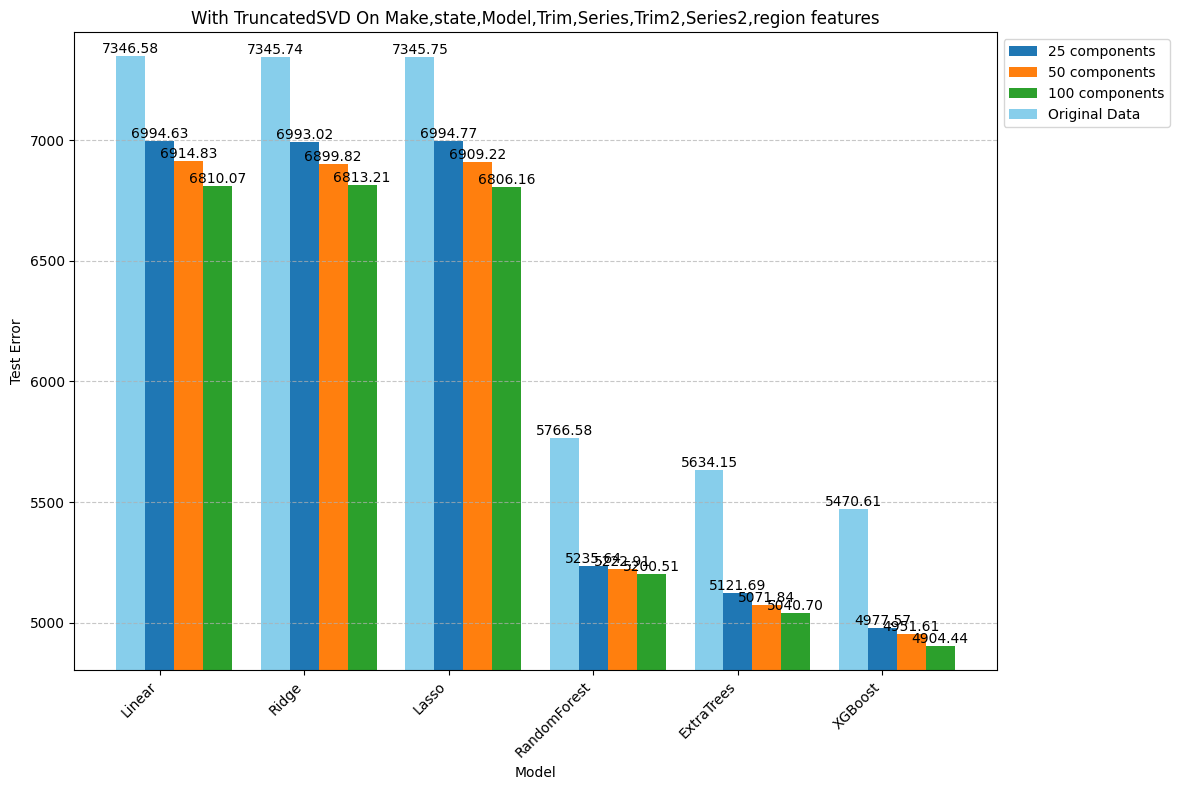

In [281]:
compare_results('With TruncatedSVD', models_dummies, n_comps, results_withoutVIN, df_scores, pca_cats)

## Final Models: CatBoost, LightGBM

In [83]:
cat_params = {
    'cat_features' : [non_pca_cats+pca_cats],
    'iterations': np.arange(200,801,100),
    'depth': np.arange(4,10,1),
    'learning_rate': np.arange(0.025, 0.151, .025),
    'l2_leaf_reg': np.arange(2, 11, 1),
    'subsample' : [0.6, 0.8, 1.0],
    'min_data_in_leaf': np.arange(1, 21, 2),
    'verbose': [False]
}

lgbm_params =  {'num_leaves': np.arange(31, 112, 5),
  'learning_rate':  np.arange(0.025, 0.151, .025),
  'n_estimators': [120, 200, 320],
  'max_depth': np.arange(4,10,1),
  'min_child_samples': [20, 50, 100],
  'subsample': [0.4, 0.6, 0.8, 1.0],
  'colsample_bytree': [0.4, 0.6, 0.8, 1.0],
  'feature_fraction': [0.4, 0.6, 0.8, 1],
    'lambda_l1': np.arange(0, 2.1, 0.1),
    'lambda_l2': np.arange(0, 2.1, 0.1),             
  'verbose': [-1]}

final_models = {'CatBoost': [CatBoostRegressor(), cat_params], 'LGBM' : [LGBMRegressor(), lgbm_params]}

In [ ]:
df_res_17 = split_search_v2(df17, non_pca_cats+pca_cats, good_number_info, 'price', StandardScaler(), 'tt', 0.2, 215, 5, 3, final_models)

In [382]:
df_res_17.sort_values(by='test')

,train,test,parameters,importances,search_time,split_method,random_state,test_size,scalar,n_iter,folds,length
LGBM,3572.008750,4394.090172,"{'verbose': -1, 'subsample': 0.6, 'num_leaves'...","{'ABS': 57, 'AdaptiveCruiseControl': 22, 'Adap...",15.160350,tt,215,0.2,StandardScaler(),5,3,89334
CatBoost,3898.817879,4515.817719,"{'verbose': False, 'subsample': 0.6, 'min_data...","{'ABS': 0.115718306123126, 'AdaptiveCruiseCont...",1734.487222,tt,215,0.2,StandardScaler(),5,3,89334


In [420]:
df_res_17['test error without 60 VIN feats'] = df_scores[df_scores.index.isin(final_models)]['test']

#### Comparison of Top Model performance with 60 new features vs. original feature set:

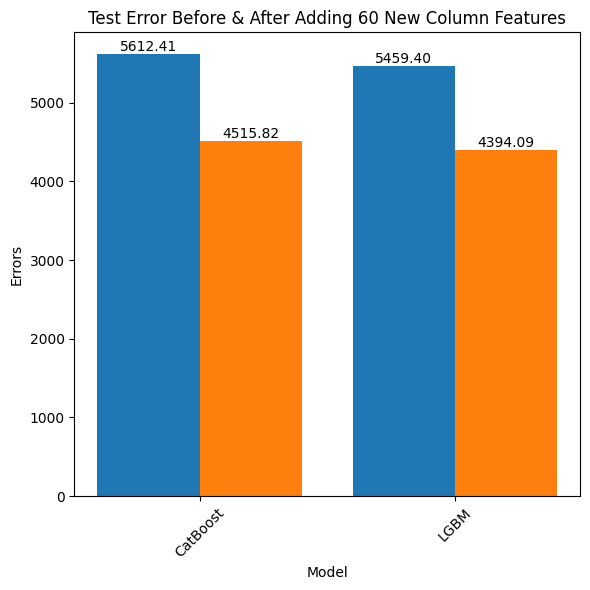

In [446]:
plot_row_values(df_res_17, ['test error without 60 VIN feats', 'test'], title='Test Error Before & After Adding 60 New Column Features', size=(6,6),Legend=False)

#### Leverage Point Test : 

Underpriced vehicles frequently only list the down payment, leading to huge, unjust errors. 

In [53]:
fakes = df17[(df17.price <= 5000) & (df17.odometer <= 105000) & (df17.ModelYear >= 2004)].index
len(fakes)

1144

In [54]:
df_dropped = df17.drop(fakes)

In [223]:
df_new5 = pd.read_csv('new5_c.csv')

In [224]:
len(df17) - len(df_new5)

2480

In [84]:
df_final_res = split_search_v2(df_dropped, non_pca_cats+pca_cats, good_number_info, 'price', StandardScaler(), 'tt', 0.2, 215, 5, 3, final_models)

CatBoost Detected
Fitting 3 folds for each of 5 candidates, totalling 15 fits
LightGBM Detected
LGBMRegressor()
Fitting 3 folds for each of 5 candidates, totalling 15 fits


In [85]:
df_test2 = split_search_v2(df_new5, non_pca_cats+pca_cats, good_number_info, 'price', MinMaxScaler(), 'tt', 0.2, 11, 5, 3, final_models)

CatBoost Detected
Fitting 3 folds for each of 5 candidates, totalling 15 fits
LightGBM Detected
LGBMRegressor()
Fitting 3 folds for each of 5 candidates, totalling 15 fits


In [253]:
df_all_models = pd.concat([df_res_17, df_final_res, df_test2])

In [255]:
df_all_models.to_csv('df_res_final.csv')

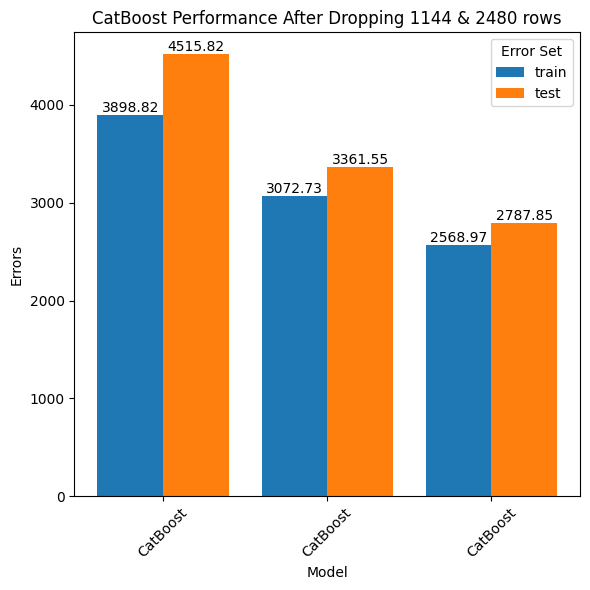

In [442]:
plot_row_values(df_all_models[df_all_models.index == 'CatBoost'], ['train', 'test'], title='CatBoost Performance After Dropping 1144 & 2480 rows', size=(6,6))

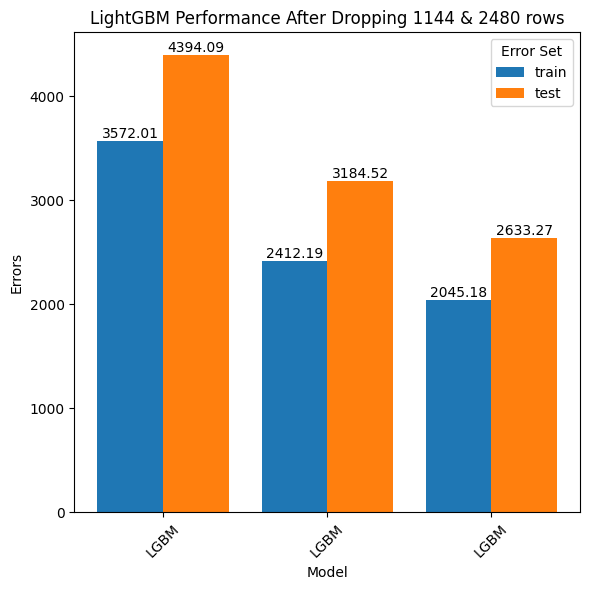

In [261]:
plot_row_values(df_all_models[df_all_models.index == 'LGBM'], ['train', 'test'], title='LightGBM Performance After Dropping 1144 & 2480 rows', size=(6,6))

In [334]:
features = list(set(lgbm_fi17_df['feature']) | set(lgbm_d1_df['feature']) | set(lgbm_d2_df['feature']))

lgbm_fi17_df = lgbm_fi17_df.set_index('feature').reindex(features).fillna(0).reset_index()
lgbm_d1_df = lgbm_d1_df.set_index('feature').reindex(features).fillna(0).reset_index()
lgbm_d2_df = lgbm_d2_df.set_index('feature').reindex(features).fillna(0).reset_index()

# Rename columns to reflect the DataFrame source
lgbm_fi17_df.columns = ['feature', 'Original']
lgbm_d1_df.columns = ['feature', 'First Drop']
lgbm_d2_df.columns = ['feature', 'Second Drop']

# Combine DataFrames
combined_df = pd.concat([lgbm_fi17_df.set_index('feature'), lgbm_d1_df.set_index('feature'), lgbm_d2_df.set_index('feature')], axis=1)
combined_df['mean'] = combined_df[['Original', 'First Drop', 'Second Drop']].mean(axis=1)
combined_df = combined_df.sort_values(by='mean',ascending=False)

### Feature Importances (LGBM)

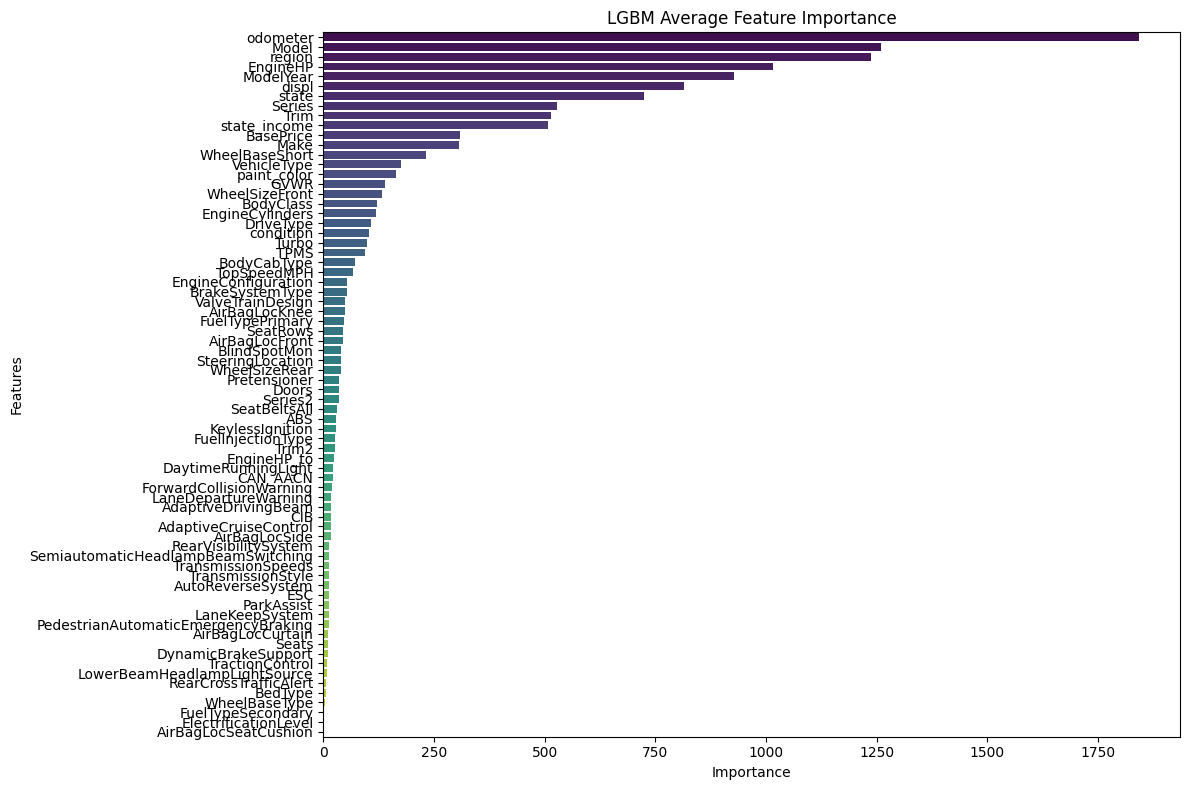

In [353]:
mean_lgbm = plot_feat_imps('LGBM Average Feature Importance', combined_df[['mean']].to_dict()['mean'])

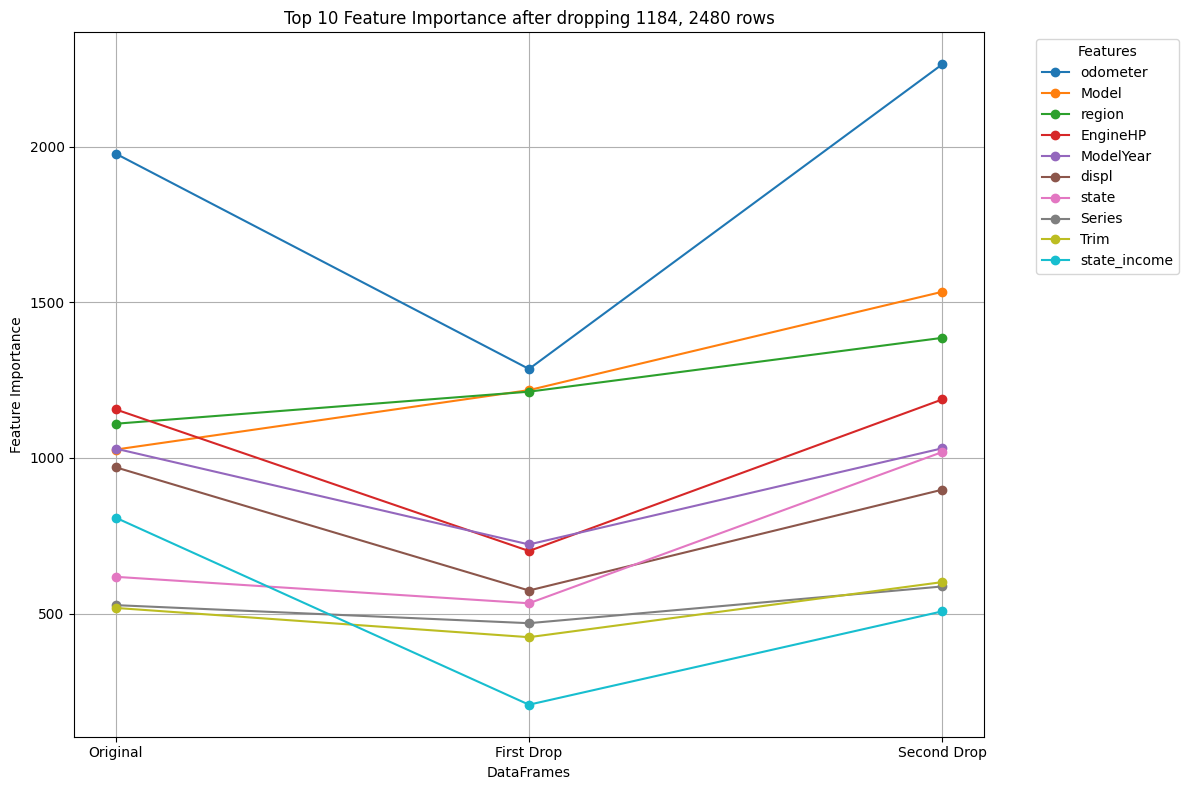

In [335]:
top_n_fts =10

plt.figure(figsize=(12, 8))

for feature in combined_df.head(top_n_fts).index:
    plt.plot(['Original', 'First Drop', 'Second Drop'], combined_df.loc[feature, ['Original', 'First Drop', 'Second Drop']], marker='o', label=feature)

plt.xlabel('DataFrames')
plt.ylabel('Feature Importance')
plt.title('Top ' + str(top_n_fts) + ' Feature Importance after dropping 1184, 2480 rows')
plt.legend(title='Features', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()  # Adjust layout to fit labels
plt.show()

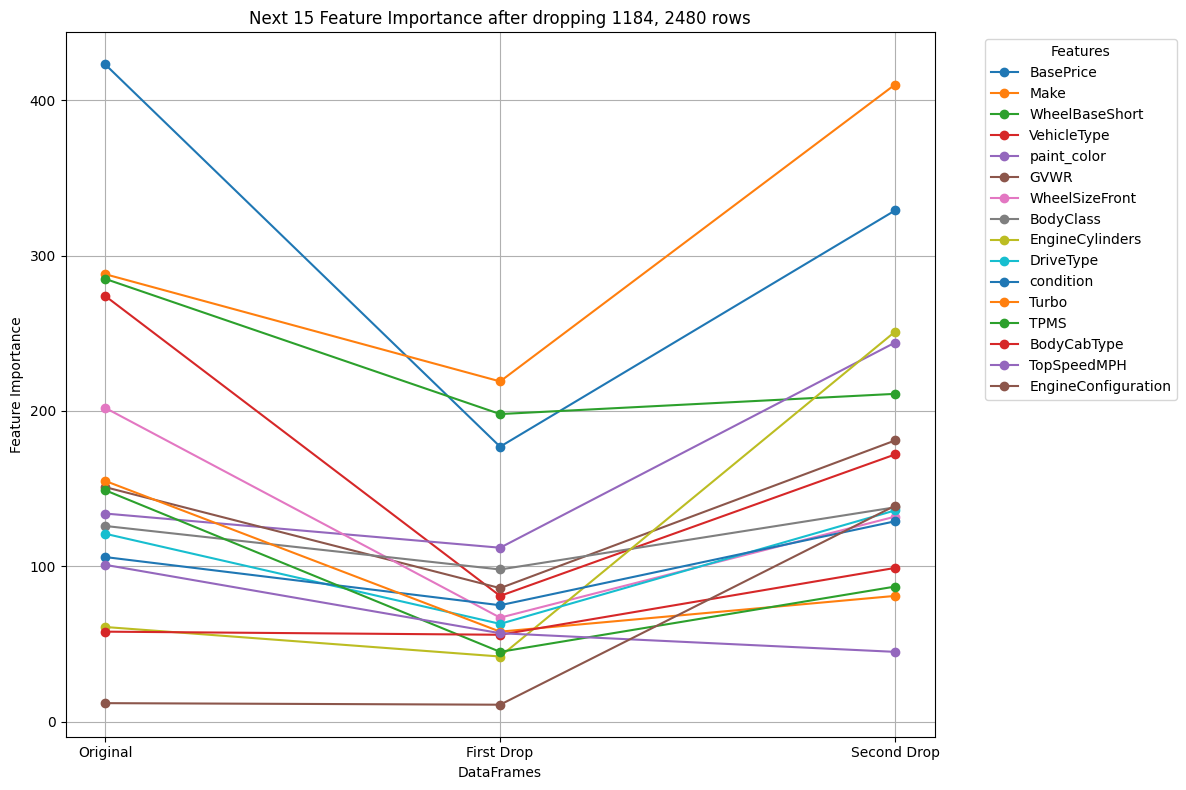

In [338]:
min_rank = 11
max_rank = 26
top_n_fts = max_rank - min_rank


# Plotting
plt.figure(figsize=(12, 8))

# Plot each feature's importance over the three changes
for feature in combined_df.iloc[(min_rank-1):max_rank].index:
    plt.plot(['Original', 'First Drop', 'Second Drop'], combined_df.loc[feature, ['Original', 'First Drop', 'Second Drop']], marker='o', label=feature)

plt.xlabel('DataFrames')
plt.ylabel('Feature Importance')
plt.title('Next ' + str(top_n_fts) + ' Feature Importance after dropping 1184, 2480 rows')
plt.legend(title='Features', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()  # Adjust layout to fit labels
plt.show()

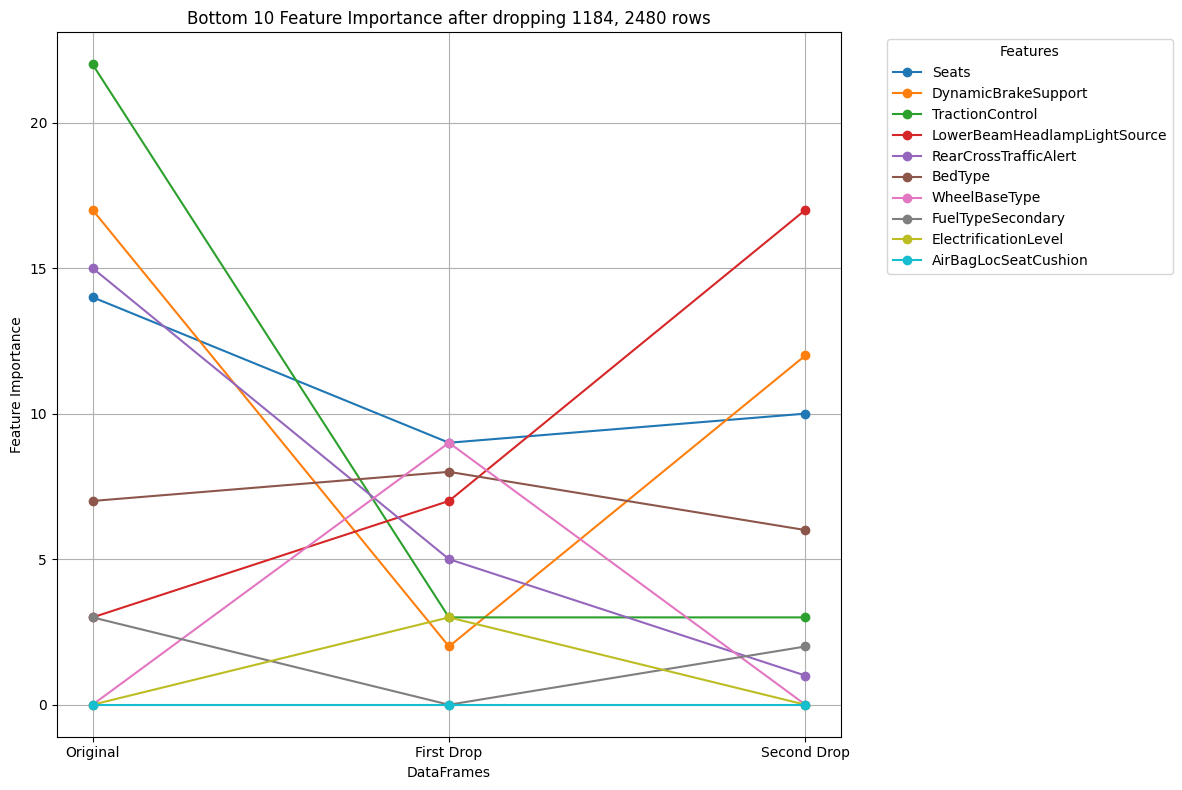

In [344]:
top_n_fts = 10


# Plotting
plt.figure(figsize=(12, 8))

# Plot each feature's importance over the three changes
for feature in combined_df.tail(top_n_fts).index:
    plt.plot(['Original', 'First Drop', 'Second Drop'], combined_df.loc[feature, ['Original', 'First Drop', 'Second Drop']], marker='o', label=feature)

plt.xlabel('DataFrames')
plt.ylabel('Feature Importance')
plt.title('Bottom ' + str(top_n_fts) + ' Feature Importance after dropping 1184, 2480 rows')
plt.legend(title='Features', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()  # Adjust layout to fit labels
plt.show()

In [346]:
def plot_feat_imps(title, feat_imp_dict):
    feature_importance_df = pd.DataFrame.from_dict(feat_imp_dict, orient='index', columns=['Importance'])
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x=feature_importance_df['Importance'], 
                y=feature_importance_df.index,
                palette=sns.color_palette('viridis', n_colors=len(feature_importance_df.index)),  # Discrete colors
                hue=feature_importance_df.index,  # Assign hue to the index for discrete color mapping
                dodge=False,  # Ensure bars do not get split by hue
                legend=False  # Remove legend if not needed
    )
    
    plt.title('Feature Importances')
    plt.xlabel('Importance')
    plt.title(title)
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()
    return feature_importance_df

In [441]:
def plot_row_values(df, columns, title='Model Comparison', x_label='Model', y_label='Errors', legend_label='Error Set', size = (12,8), Legend=True,loc='upper right'):
    missing_columns = [col for col in columns if col not in df.columns]
    if missing_columns:
        raise ValueError(f"Columns {missing_columns} are not in the DataFrame.")

    num_rows = len(df)
    num_columns = len(columns)
    
    bar_width = 0.8 / num_columns
    indices = np.arange(num_rows)
    
    fig, ax = plt.subplots(figsize=size)
    
    for i, col in enumerate(columns):
        offset = i * bar_width
        bars = ax.bar(indices + offset, df[col], bar_width, label=col)
        
        for bar in bars:
            yval = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.2f}', ha='center', va='bottom')
    
    ax.set_xticks(indices + bar_width * (num_columns - 1) / 2)
    ax.set_xticklabels(df.index, rotation=45)
    
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    if Legend == True:
        ax.legend(loc=loc, title=legend_label)
    
    plt.tight_layout()
    plt.show()


In [94]:
def compare_results(pca_method, model_ls, n_comps, results, compare_df, feats_pca):
    
    results_df = pd.DataFrame(results)
    dfdc = {}

    if n_comps:
        for n in n_comps:
            df = results_df[(results_df['n_components'] == n) & (results_df['model_name'].isin(model_ls))]
            df = df.set_index('model_name').reindex(model_ls).fillna(0)
            dfdc[n] = df['test_error']

    compare_df = compare_df.reindex(model_ls).fillna(0)

    num_models = len(model_ls)
    num_comps = len(n_comps)
    width = 0.8 / (num_comps + 1) 
    x = np.arange(num_models) 

    plt.figure(figsize=(14, 8))

    for i, n in enumerate(n_comps):
        bars = plt.bar(x + i * width, dfdc[n], width, label=f'{n} components')

        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')

    bars_original = plt.bar(x - width, compare_df['test'], width, label='Original Data', color='skyblue')
    for bar in bars_original:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')

    min_value = min(compare_df['test'].min(), *[dfdc[n].min() for n in n_comps])
    max_value = max(compare_df['test'].max(), *[dfdc[n].max() for n in n_comps])

    plt.ylim(min_value - 100, max_value + 100)
    plt.xlabel('Model')
    plt.ylabel('Test Error')
    plt.title(pca_method + ' On ' + ','.join(feats_pca) + ' features')
    plt.xticks(x, compare_df.index, rotation=45, ha='right')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    
    # Show the plot
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to make room for legend
    plt.show()

In [95]:
def merge_dc(dict1, dict2):
    res = {**dict1, **dict2}
    return res

In [96]:
# Accepts model class: TruncatedSVD or model instance: TruncatedSVD()

def create_model_with_params(model, params):
    if isinstance(model, type):  # Check if 'model' is a class
        model_class = model
    elif hasattr(model, '__class__'):  # Check if 'model' is an instance
        model_class = model.__class__
    else:
        raise ValueError("The 'model' parameter must be a class or an instance.")
    
    return model_class(**params)
